# 1 - Imports and Loading Data

In [21]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import nltk
from sms_spam_utils import tokenize, lem, count_words, get_word_freq, count_punctuation, count_uppercase_words

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# These packages may need to be downloaded the first time running this code.
#nltk.download('punkt_tab')
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [22]:
# Load the data
try:
    df = pd.read_csv('spam.csv', encoding='latin-1') # Had to use latin-1 as spam.csv isn't UTF-8 encoded
    df = df[['v1', 'v2']] # Keep only necessary columns
    df = df.rename(columns={'v1': 'label', 'v2': 'text'})
except FileNotFoundError:
    print("Error: spam.csv not found.")
    exit()

print("\n--- Data Info ---")
df.info() # Found no missing values

print("\n--- Data Set ---")
df


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

--- Data Set ---


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# 2 - Exploratory Data Analysis


--- Label Distribution ---
label
ham     4825
spam     747
Name: count, dtype: int64


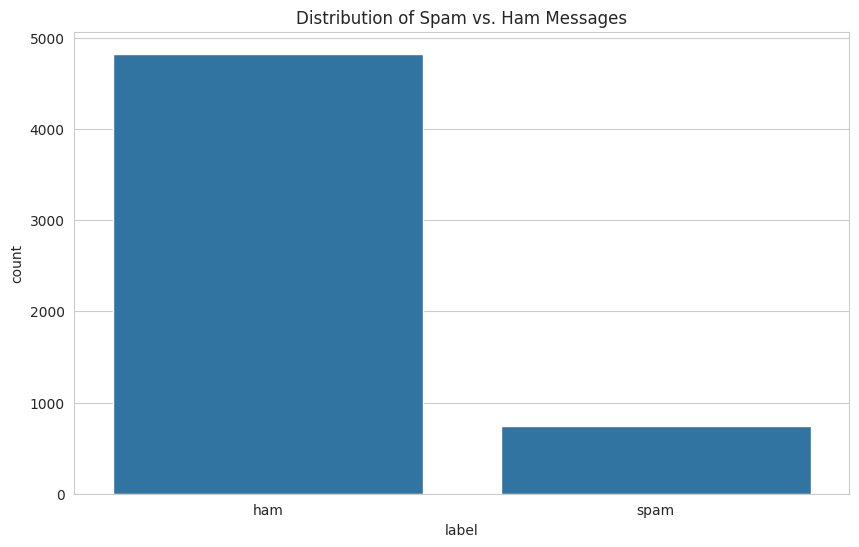


--- Message Length Statistics by Label ---
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


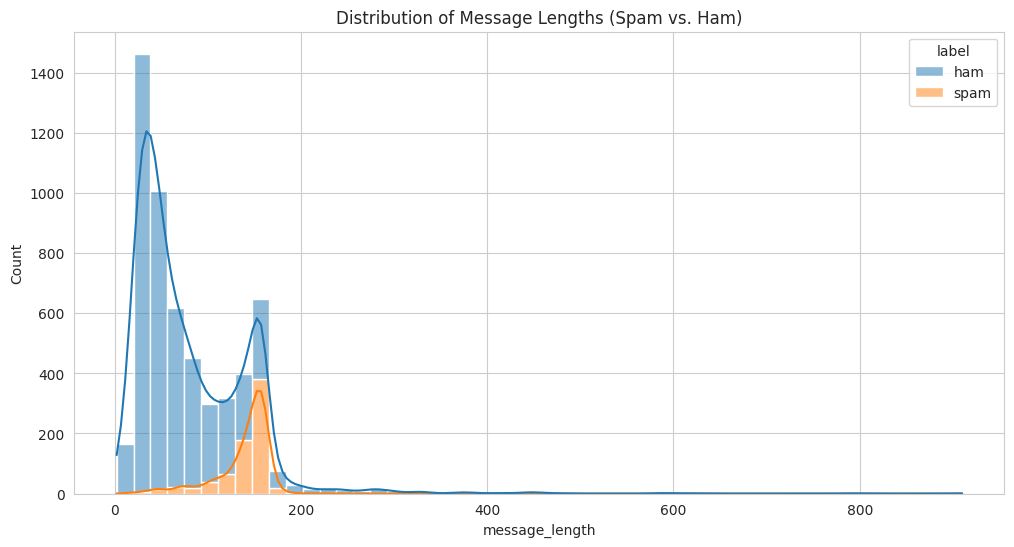


--- Word Count Statistics by Label ---
        count       mean       std  min   25%   50%   75%   max
label                                                          
ham    4825.0   7.921451  6.336200  0.0   4.0   6.0  10.0  74.0
spam    747.0  15.381526  4.728878  1.0  12.0  16.0  18.0  28.0


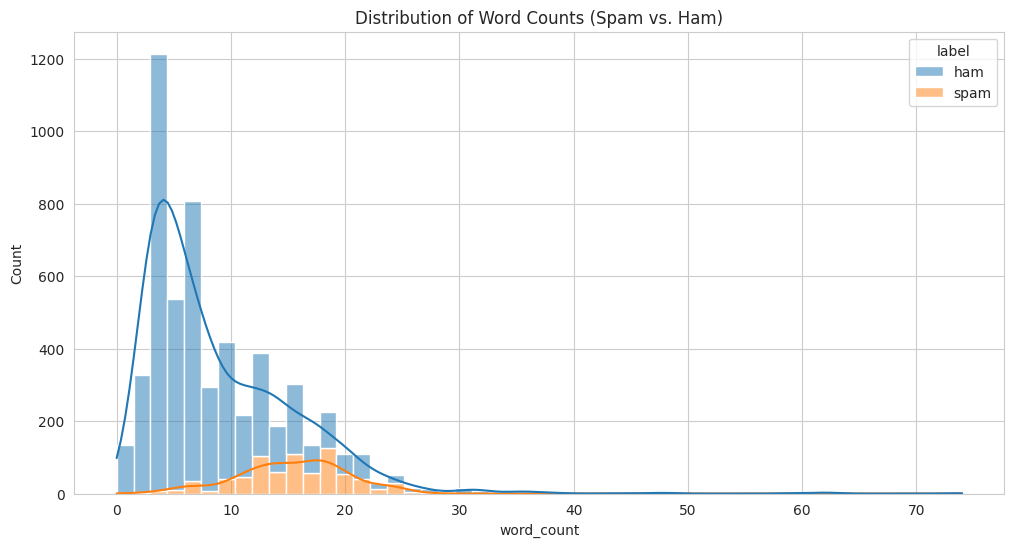


--- Top 10 Words in Spam Messages ---
[('call', 365), ('free', 219), ('2', 174), ('txt', 156), ('u', 149), ('ur', 144), ('text', 138), ('mobile', 133), ('4', 120), ('claim', 115)]

--- Top 10 Words in Ham Messages ---
[('u', 1035), ('get', 600), ('go', 520), ('come', 320), ('gt', 318), ('lt', 316), ('2', 300), ('call', 291), ('know', 260), ('good', 253)]


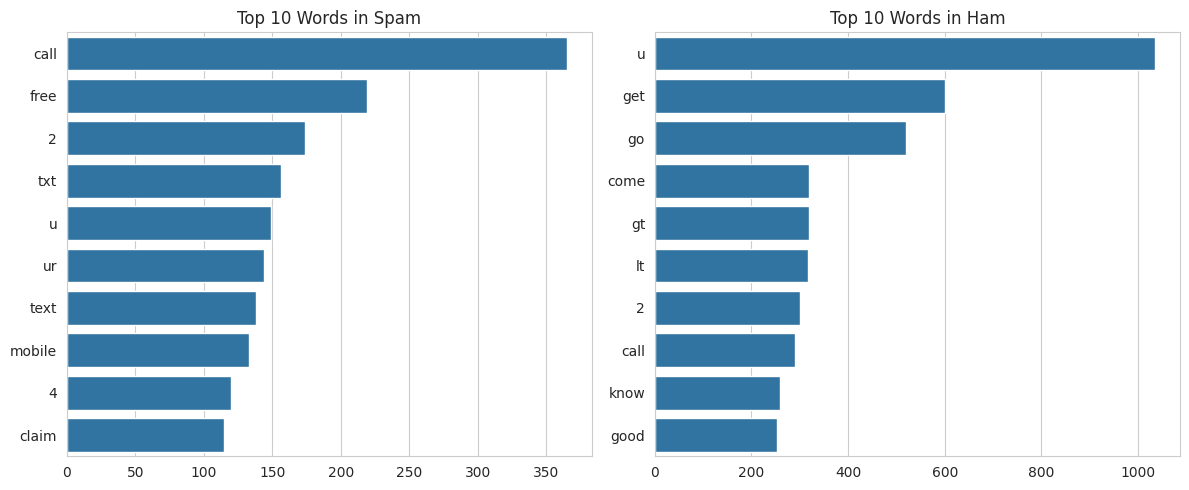


--- Punctuation Count Statistics by Label ---
        count      mean       std  min  25%  50%  75%    max
label                                                       
ham    4825.0  3.974508  4.767563  0.0  1.0  3.0  5.0  133.0
spam    747.0  5.714859  3.453301  0.0  3.0  5.0  8.0   26.0

--- Uppercase Word Count Statistics by Label ---
        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4825.0  0.433990  2.275365  0.0  0.0  0.0  0.0  33.0
spam    747.0  2.373494  2.633257  0.0  1.0  2.0  3.0  24.0


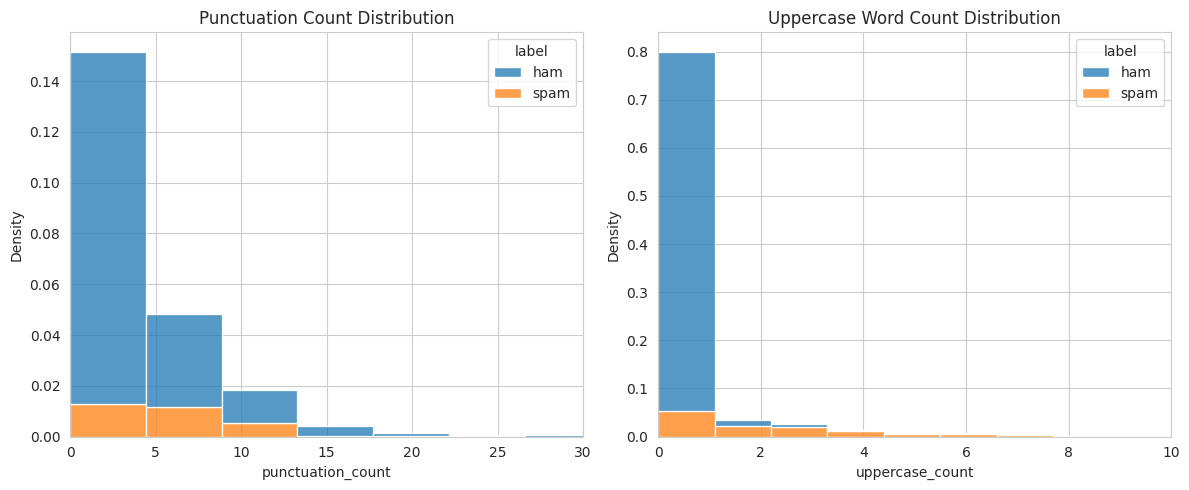

In [23]:
# Plot for label distribution
print("\n--- Label Distribution ---")
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs. Ham Messages')
plt.show()

# --------------------------------------------------------------------------------------------
# Apply functions to dataset
df['message_length'] = df['text'].apply(len)

# Stats
print("\n--- Message Length Statistics by Label ---")
print(df.groupby('label')['message_length'].describe())

# Vizualize
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='message_length', hue='label', multiple='stack', bins=50, kde=True)
plt.title('Distribution of Message Lengths (Spam vs. Ham)')
plt.show()

# --------------------------------------------------------------------------------------------
# Apply functions to dataset
df['word_count'] = df['text'].apply(count_words)

# Stats
print("\n--- Word Count Statistics by Label ---")
print(df.groupby('label')['word_count'].describe())

# Visualize
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', multiple='stack', bins=50, kde=True)
plt.title('Distribution of Word Counts (Spam vs. Ham)')
plt.show()

# --------------------------------------------------------------------------------------------
# Split by label
spam_texts = df[df['label'] == 'spam']['text']
ham_texts = df[df['label'] == 'ham']['text']

# Compute frequencies
spam_word_freq = get_word_freq(spam_texts)
ham_word_freq = get_word_freq(ham_texts)

print("\n--- Top 10 Words in Spam Messages ---")
print(spam_word_freq)
print("\n--- Top 10 Words in Ham Messages ---")
print(ham_word_freq)

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=[count for _, count in spam_word_freq], y=[word for word, _ in spam_word_freq])
plt.title('Top 10 Words in Spam')
plt.subplot(1, 2, 2)
sns.barplot(x=[count for _, count in ham_word_freq], y=[word for word, _ in ham_word_freq])
plt.title('Top 10 Words in Ham')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------------
# Apply functions to dataset
df['punctuation_count'] = df['text'].apply(count_punctuation)
df['uppercase_count'] = df['text'].apply(count_uppercase_words)

# Stats
print("\n--- Punctuation Count Statistics by Label ---")
print(df.groupby('label')['punctuation_count'].describe())
print("\n--- Uppercase Word Count Statistics by Label ---")
print(df.groupby('label')['uppercase_count'].describe())

# Vizualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='punctuation_count', hue='label', multiple='stack', bins=30, stat='density')
plt.title('Punctuation Count Distribution')
plt.xlim(0, 30)  # Limit to typical range
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='uppercase_count', hue='label', multiple='stack', bins=30, stat='density')
plt.title('Uppercase Word Count Distribution')
plt.xlim(0, 10)  # Limit to typical range
plt.tight_layout()
plt.show()

# 3 - Preprocessing

In [17]:
# Preprocess text by using util functions
def preprocess_text(text):
    text = text.replace('>', '').replace('<', '')
    tokens = tokenize(text)
    pos_tags = [tag for _, tag in nltk.pos_tag(tokens)]
    lemmatized = lem(tokens, pos_tags)
    return ' '.join(lemmatized)

# Apply preprocessing to the text column
df['clean_text'] = df['text'].apply(preprocess_text)

# Encode labels by converting 'ham' to 0 and 'spam' to 1
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Compute additional features
df['word_count'] = df['text'].apply(count_words)
df['punctuation_count'] = df['text'].apply(count_punctuation)
df['uppercase_count'] = df['text'].apply(count_uppercase_words)

# Spam keywords (from EDA, and assumed common in spam messages)
spam_keywords = ['free', 'win', 'prize', 'call', 'claim']
for keyword in spam_keywords: # Create binary features for the presence of each spam keyword in the cleaned text
    df[f'has_{keyword}'] = df['clean_text'].apply(lambda x: 1 if keyword in x.split() else 0)

# Display samples with new features added
print("\n--- Sample Preprocessed Text with Features ---")
print(df[['text', 'clean_text', 'word_count', 'punctuation_count', 'uppercase_count', 'has_free', 'has_win', 'label']])


--- Sample Preprocessed Text with Features ---
                                                   text  \
0     Go until jurong point, crazy.. Available only ...   
1                         Ok lar... Joking wif u oni...   
2     Free entry in 2 a wkly comp to win FA Cup fina...   
3     U dun say so early hor... U c already then say...   
4     Nah I don't think he goes to usf, he lives aro...   
...                                                 ...   
5567  This is the 2nd time we have tried 2 contact u...   
5568              Will Ì_ b going to esplanade fr home?   
5569  Pity, * was in mood for that. So...any other s...   
5570  The guy did some bitching but I acted like i'd...   
5571                         Rofl. Its true to its name   

                                             clean_text  word_count  \
0     go jurong point crazy available bugis n great ...          16   
1                                 ok lar joke wif u oni           6   
2     free entry 2 wkly comp w

# 4 - Vocab and Features Included

In [18]:
# Combine the engineered numerical features into a NumPy array
additional_features = df[['word_count', 'punctuation_count', 'uppercase_count', 'has_free', 'has_win', 'has_prize', 'has_call', 'has_claim']].values

# Binary Bag of Words (using CountVectorizer with binary=True)
binary_vectorizer = CountVectorizer(max_features=7056, stop_words=None, min_df=1, binary=True)
X_binary = binary_vectorizer.fit_transform(df['clean_text']).toarray()
X_binary = np.hstack([X_binary, additional_features]) # Horizontally stack features with the additional features
y = df['label_encoded'].values
print(f"\n--- Binary Bag of Words Shape with Features: {X_binary.shape} ---")

# Term Frequency Bag of Words (using CountVectorizer default)
tf_vectorizer = CountVectorizer(max_features=7056, stop_words=None, min_df=1)
X_tf = tf_vectorizer.fit_transform(df['clean_text']).toarray()
X_tf = np.hstack([X_tf, additional_features])
print(f"\n--- Term Frequency Bag of Words Shape with Features: {X_tf.shape} ---")

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=7056, stop_words=None, min_df=1)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text']).toarray()
X_tfidf = np.hstack([X_tfidf, additional_features])
print(f"\n--- TF-IDF Shape with Features: {X_tfidf.shape} ---")


--- Binary Bag of Words Shape with Features: (5572, 7064) ---

--- Term Frequency Bag of Words Shape with Features: (5572, 7064) ---

--- TF-IDF Shape with Features: (5572, 7064) ---


### Note:
Found that the initial bag_of_words vocabulary (7082 words) included single letters, numbers, and short tokens (e.g., 'f', '1', 'ukp') due to lem() and tokenize, while CountVectorizer and TfidfVectorizer (7056 words) excluded these using stricter tokenization rules. This made me change bag_of_words' vocabulary to the vectorizers' vocabulary (vectorizer.vocabulary_) to ensure consistency across methods.

```python
# After CountVectorizer
print(f"CountVectorizer Vocabulary Size: {len(vectorizer.vocabulary_)}")
# After TfidfVectorizer
print(f"TfidfVectorizer Vocabulary Size: {len(tfidf_vectorizer.vocabulary_)}")

# Get vocabularies
bow_vocab = set(vocabulary)
count_vocab = set(vectorizer.vocabulary_.keys())
# Find differences
missing_in_count = bow_vocab - count_vocab
print(f"Words in BoW vocab but not in CountVectorizer: {missing_in_count}")
```
```
CountVectorizer Vocabulary Size: 7056
TfidfVectorizer Vocabulary Size: 7056
Words in BoW vocab but not in CountVectorizer: {'f', 'w', 'v', 't', 'p', '3', 'x', 'n', '21870000', 'e', 'q', '1', 'm', 'l', '4', '2', 'ukp', 'c', 'h', '6', 'j', 'g', '5', 'o', '0', '8', '7', 'b', '448712404000', 'k', 'z', 'u', 'r', '9
```'}

# 5 - Split the Data

In [19]:
# Split for Binary Bag of Words
X_train_binary, X_test_binary, y_train, y_test = train_test_split(X_binary, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n--- Binary Bag of Words Training Set: {X_train_binary.shape}, Test Set: {X_test_binary.shape} ---")

# Split for Term Frequency Bag of Words
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n--- Term Frequency Bag of Words Training Set: {X_train_tf.shape}, Test Set: {X_test_tf.shape} ---")

# Split for TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
3print(f"\n--- TF-IDF Training Set: {X_train_tfidf.shape}, Test Set: {X_test_tfidf.shape} ---")
# Stratifying ensures that the proportion of spam/ham is similar in train and test sets


--- Binary Bag of Words Training Set: (4457, 7064), Test Set: (1115, 7064) ---

--- Term Frequency Bag of Words Training Set: (4457, 7064), Test Set: (1115, 7064) ---

--- TF-IDF Training Set: (4457, 7064), Test Set: (1115, 7064) ---


# 6 - Model Training

In [20]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear')
}

# Evaluate models with Binary Bag of Words features
print("\n--- Model Evaluation with Binary Bag of Words ---")
for name, model in models.items():
    model.fit(X_train_binary, y_train) # Train the model
    y_pred = model.predict(X_test_binary) # Make predictions on the test set
    accuracy = accuracy_score(y_test, y_pred) # Calculate accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
    cm = confusion_matrix(y_test, y_pred) # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel() # Unpack confusion matrix components
    print(f"Confusion Matrix:\n{cm}")
    print(f"TN (Ham as Ham): {tn}, FP (Ham as Spam): {fp}")
    print(f"FN (Spam as Ham): {fn}, TP (Spam as Spam): {tp}\\n")

# Evaluate with Term Frequency Bag of Words
print("\n--- Model Evaluation with Term Frequency Bag of Words ---")
for name, model in models.items():
    model.fit(X_train_tf, y_train)
    y_pred = model.predict(X_test_tf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix:\n{cm}")
    print(f"TN (Ham as Ham): {tn}, FP (Ham as Spam): {fp}")
    print(f"FN (Spam as Ham): {fn}, TP (Spam as Spam): {tp}\n")

# Evaluate with TF-IDF
print("\n--- Model Evaluation with TF-IDF ---")
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix:\n{cm}")
    print(f"TN (Ham as Ham): {tn}, FP (Ham as Spam): {fp}")
    print(f"FN (Spam as Ham): {fn}, TP (Spam as Spam): {tp}\n")


--- Model Evaluation with Binary Bag of Words ---
Logistic Regression Accuracy: 0.9839
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[964   2]
 [ 16 133]]
TN (Ham as Ham): 964, FP (Ham as Spam): 2
FN (Spam as Ham): 16, TP (Spam as Spam): 133

Naive Bayes Accuracy: 0.9677
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.91      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[944  22]
 [ 14 135]]
TN (Ham as Ham): 944, FP (Ham as Spam): 22
FN (Spam as Ham)

# 7 - Train and Save Best Performing Model

In [13]:
# Train and save the best model (SVM with Binary Bag of Words)
best_model = SVC(kernel='linear')
best_model.fit(X_train_binary, y_train)

# Save the best model, vectorizer, and spam keywords for the Gradio interface
model_data = {
    'model': best_model,
    'vectorizer': binary_vectorizer,  # Save the binary vectorizer for the interface
    'spam_keywords': spam_keywords
}
with open('sms_spam_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print("Model saved as sms_spam_model.pkl")

Model saved as sms_spam_model.pkl
